### To replicate our results or use our algorithm to analyze your own single-cell dataset, please follow the steps below:

1. Install the relevant packages.

2. To replicate the results, download the dataset and replace the file path with your own.

3. To run the algorithm on your dataset, ensure that your data is in the AnnData format.

# Install and read Package for running QOT

1.   Run the following code to install relavent package
2.   Connect to Google-Drive to download dataset
3.   Change the file path of the dataset before Run corresponding cell

In [ ]:
!pip install POT
!pip install hdbscan
!pip install scanpy
!pip install phate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.0 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=1486267e5f6c5b15e543dface882f52a0e46858b3648b1af9c9b7dd757f27381
  Stored in direct

In [ ]:
import importlib
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc
import phate
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path to the file in Google Drive
from google.colab import drive

drive.mount('/content/drive')

file_path = '"/content/drive/My Drive/Datasets.tar.gz"'

# Define the directory in Colab where you want to extract the contents
extract_dir = '/content/datasets'

# Create the directory if it doesn't exist
!mkdir -p {extract_dir}

# Unzip the file
!tar -xzvf {file_path} -C {extract_dir}

# List the contents of the extracted directory
!ls {extract_dir}

Mounted at /content/drive
Datasets/Covid_19_PBMC.h5ad
Datasets/PDAC.RDS
^C
Datasets


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import ot
import scipy.stats as sps
import scipy.linalg as spl
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import phate as ph
def Extract_Info(adata, gene_matrix='X_PCA', type_cell='cell_types',id='sampleID',progession='status',dataset_type = 'pathomic'):
    """
    Create a combined DataFrame from PCA results and annotations in adata_T.

    Parameters:
    adata_T (Anndata object): An object containing PCA results and annotations.

    Returns:
    DataFrame: A combined DataFrame with PCA results and annotations.
    """

    # Convert PCA results to a DataFrame and reset index
    if dataset_type =='pathomic':
        pca_results_df = pd.DataFrame(adata.X).reset_index(drop=True)
    else:
        pca_results_df = pd.DataFrame(adata.obsm[gene_matrix]).reset_index(drop=True)
    # Reset the index for 'sampleID' and 'cell_subtype'
    sample_ids = adata.obs[id].reset_index(drop=True)
    cell_subtypes = adata.obs[type_cell].reset_index(drop=True)
    status = adata.obs[progession].reset_index(drop=True)

    # Concatenate the PCA results with 'sampleID', 'cell_subtype', and 'status'
    combined_pca_df = pd.concat([pca_results_df, sample_ids, cell_subtypes, status], axis=1)

    # Rename columns
    combined_pca_df = combined_pca_df.rename(columns={type_cell: 'Cell_type',
                                                      id: 'sampleID',
                                                      progession: 'status'})

    adata.uns['Datafame_for_use'] = combined_pca_df



def Gaussian_Mixture_Representation(adata, num_components=5, random_state=2, min_samples_for_gmm=0):
    """
    Process the given DataFrame using Gaussian Mixture Models (GMM).

    Parameters:
    df (DataFrame): The input data frame.
    num_components (int): The number of components for GMM.
    random_state (int): The seed for the random number generator.
    min_samples_for_gmm (int): Minimum number of samples required for fitting GMM.

    Returns:
    dict: A dictionary containing GMM parameters for each (source, label) pair.
    """
    df = adata.uns['Datafame_for_use']
    # Uncomment if you need to filter or drop columns initially
    df = df[df['Cell_type'] != 'Unknown']
    df = df.drop(['status'], axis=1)

    grouped = df.groupby(['sampleID', 'Cell_type'])
    gmm_count_per_source = {}
    params = {}

    for (source, label), group in grouped:
        data = group.drop(['sampleID', 'Cell_type'], axis=1)
        num_samples = data.shape[0]

        if num_samples >= num_components + min_samples_for_gmm:
            gmm = GaussianMixture(n_components=num_components, random_state=random_state).fit(data)

            key = (source, label)
            params[key] = {
                'means': gmm.means_,
                'covariances': gmm.covariances_,
                'weights': gmm.weights_,
                'proportion': len(group) / len(df[df['sampleID'] == source])
            }

        elif num_samples == 1:  # Exactly 1 samples, use itself
            mean_sample = data.iloc[0].values.reshape(1, -1)
            key = (source, label)
            params[key] = {
            'means': mean_sample,
            'covariances': np.zeros((1, data.shape[1], data.shape[1])),
            'weights': np.array([1]),
            'proportion': len(group) / len(df[df['sampleID'] == source])
            }
        elif num_samples == 2:  # Exactly 2 samples, use mean
            mean_sample = data.mean(axis=0).values.reshape(1, -1)
            key = (source, label)
            params[key] = {
            'means': mean_sample,
            'covariances': np.zeros((1, data.shape[1], data.shape[1])),
            'weights': np.array([1]),
            'proportion': len(group) / len(df[df['sampleID'] == source])
            }

    adata.uns['GMM_Representation'] = params


def euclidean_distance(vec1, vec2):
    """Calculate the Euclidean distance between two vectors."""
    return np.linalg.norm(vec1 - vec2)

def cosine_similarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


def GaussianW2(m0,m1,Sigma0,Sigma1):
    # compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d



def calculate_qot(adata, method = "alternative",normalized = False):
    """
    Calculate the GW2 distance between sources.

    Parameters:
    sources (list): List of source names.
    params (dict): Dictionary containing GMM parameters.
    df (pandas.DataFrame): DataFrame containing cell types.
    GW2 (function): Function to calculate GW2 distance.

    Returns:
    np.ndarray: Distance matrix containing GW2 distances between sources.
    """
    params = adata.uns['GMM_Representation']
    df = adata.uns['Datafame_for_use']
    sources = df['sampleID'].unique()

    num_sources = len(sources)
    total_calculations = (num_sources * (num_sources - 1)) // 2
    distance_matrix = np.zeros((num_sources, num_sources))
    calculation_count = 0
    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            if i < j:
                calculation_count += 1
                # print(f"Calculating GW2 distance {calculation_count}/{total_calculations}: {source1} to {source2}")

                # print("celltype_lens  ", len(df['Cell_type'].unique()))
                arrays_to_concat1 = [params[(source1, cell_type)]['means']
                                     for cell_type in df['Cell_type'].unique()
                                     if (source1, cell_type) in params and params[(source1, cell_type)]['means'].size > 0]

                arrays_to_concat2 = [params[(source2, cell_type)]['means']
                                     for cell_type in df['Cell_type'].unique()
                                     if (source2, cell_type) in params and params[(source2, cell_type)]['means'].size > 0]

                # Check if either list is empty after filtering
                if not arrays_to_concat1 or not arrays_to_concat2:
                    print(f"Skipping distance calculation for {source1} and {source2} due to missing data.")
                    continue


                means1 = np.concatenate(arrays_to_concat1) if arrays_to_concat1 else np.array([])
                means2 = np.concatenate(arrays_to_concat2) if arrays_to_concat2 else np.array([])



                covs1 = np.concatenate([params[(source1, cell_type)]['covariances']
                                        for cell_type in df['Cell_type'].unique()
                                        if (source1, cell_type) in params])

                covs2 = np.concatenate([params[(source2, cell_type)]['covariances']
                                        for cell_type in df['Cell_type'].unique()
                                        if (source2, cell_type) in params])
                weights1 = np.concatenate([params[(source1, cell_type)]['weights'] * params[(source1, cell_type)]['proportion']
                           for cell_type in df['Cell_type'].unique()
                           if (source1, cell_type) in params and params[(source1, cell_type)]['weights'].size > 0])

                weights2 = np.concatenate([params[(source2, cell_type)]['weights'] * params[(source2, cell_type)]['proportion']
                           for cell_type in df['Cell_type'].unique()
                           if (source2, cell_type) in params and params[(source2, cell_type)]['weights'].size > 0])


                weights1 = weights1 / np.sum(weights1)
                weights2 = weights2 / np.sum(weights2)



                if len(means1) > 0 and len(means2) > 0 and len(weights1) > 0 and len(weights2) > 0:
                    _, distGW2 = GW2(weights1, weights2, means1, means2, covs1, covs2,method ,normalized)
                    distance_matrix[i, j] = distGW2
                    distance_matrix[j, i] = distGW2
    adata.uns['QOT_Distance'] = distance_matrix



def normalize_matrix(mat):
    min_val = np.min(mat)
    max_val = np.max(mat)
    range_val = max_val - min_val
    if range_val == 0:
        return mat - min_val
    else:
        return (mat - min_val) / range_val

def GW2(pi0,pi1,mu0,mu1,S0,S1,method,normalized):
    alpha = 1

    # return the GW2 discrete map and the GW2 distance between two GMM
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    M  = np.zeros((K0,K1))
    trace_cov_sim_matrix= np.zeros((K0,K1))
    angle_sim_matrix= np.zeros((K0,K1))
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):

            if method== "cosine":
                angle_similarity = cosine_similarity(mu0[k, :], mu1[l, :])
                M[k, l] = (1 - angle_similarity)

            elif method =="euclidean":


                M[k, l]  = euclidean_distance(mu0[k, :], mu1[l, :])

            elif method== "exact":

                M[k, l] = GaussianW2(mu0[k,:], mu1[l,:], S0[k,:,:], S1[l,:,:])

    if normalized == True:
      M = normalize_matrix(M)


    wstar     = ot.emd(pi0,pi1,M)         # discrete transport plan

    distGW2   = np.sum(wstar*M)
    return wstar,distGW2


import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def visualize_and_evaluate(adata, cmap='Blues_r', metric='precomputed'):
    """
    Normalizes the matrix, creates a heatmap, and calculates the silhouette score.

    Parameters:
    qot_labeled (array-like): The data to be normalized and visualized.
    labels (array-like): The labels for silhouette score calculation.
    cmap (str): The colormap for the heatmap.
    metric (str): The metric to use for silhouette score calculation.

    Returns:
    float: The silhouette score.
    """
    qot = adata.uns['QOT_Distance']
    df =  adata.uns['Datafame_for_use']
    # Normalize the matrix (assuming normalize_matrix is a defined function)
    normalized_matrix = normalize_matrix(qot)
    # Get unique sampleIDs in the order they appear from end to beginning
    unique_sampleIDs = df['sampleID'].unique()

# Initialize an empty list to hold the status for each unique sampleID
    true_labels = []

# Iterate over the unique sampleIDs
    for sampleID in unique_sampleIDs:
    # Find the status for the current sampleID
        status = df[df['sampleID'] == sampleID]['status'].iloc[0]
    # Append the found status to the true_labels list
        true_labels.append(status)

# Convert true_labels to a numpy array
    true_labels_array = np.array(true_labels)
    # Create heatmap
    sources = df['sampleID'].unique()
    qot_labeled_df = pd.DataFrame(normalized_matrix, index=sources, columns=sources)
    sns.clustermap(qot_labeled_df, cmap='Blues_r', figsize=(6, 6))
    plt.suptitle("QOT", y=1.05)
    plt.show()

    # Calculate and print the silhouette score
    score_1 = silhouette_score(normalized_matrix, true_labels_array, metric=metric)
    print("Silhouette Score:", score_1)

    score_2 = silhouette_score(normalized_matrix, true_labels_array, metric="cosine")
    print("Silhouette Score (PILOT Version):", score_2)
    return score_1,score_2
def custom_encode(labels,dataset_name):
    if dataset_name == "MYIO":
        mapping = {'IZ': 1, 'control': 0}
    elif dataset_name == "KID_T":
        mapping = {'<30': 2, '30-60': 1, '>60': 0}
    elif dataset_name == "KID_G":
        mapping = {'<30': 2, '30-60': 1, '>60': 0}
    elif dataset_name == "PDAC":
        mapping = {'T': 1, 'N': 0}
    elif dataset_name == "Kidney_AC_G":
        mapping = {'Case': 1, 'Normal': 0}
    elif dataset_name == "Kidney_AC_T":
        mapping = {'Case': 1, 'Normal': 0}
    elif dataset_name == "Covid":
        mapping = {'severe/critical': 2, 'mild/moderate': 1, 'control': 0}
    elif dataset_name == "Lupus":
        mapping = {'Case': 1, 'Healthy': 0}
    elif dataset_name == "FOLL":
        mapping = {'follicular lymphoma': 1, 'normal': 0}
    elif dataset_name == "Kidney_RNA":
        mapping ={'Normal': 0, 'chronic kidney disease': 1, 'acute kidney failure': 2}
    elif dataset_name == "diabete":
        mapping ={'normal': 0, 'type 2 diabetes mellitus': 2, 'endocrine pancreas disorder': 1, 'type 1 diabetes mellitus': 2}
    return np.array([mapping[label] for label in labels])

def perform_analysis_phate_and_calculate_aucpr(adata,knn_number=5,dataset_name = 'PDAC',flip_condition = False ):
    """
    Perform PHATE analysis and calculate AUCPR.

    Parameters:
    data (DataFrame or ndarray): The high-dimensional data.
    labels (Series or list): The labels for the data.
    custom_mapping (dict): Mapping for custom encoding of labels.
    true_label_array (list): Array of true labels for AUCPR calculation.

    Returns:
    float: The average AUCPR score.
    """
    qot = adata.uns['QOT_Distance']
    df =  adata.uns['Datafame_for_use']
    # Initialize PHATE
    true_labels = []
    unique_sampleIDs = df['sampleID'].unique()

# Initialize an empty list to hold the status for each unique sampleID
    true_labels = []
    # Iterate over the unique sampleIDs
    for sampleID in unique_sampleIDs:
    # Find the status for the current sampleID
        status = df[df['sampleID'] == sampleID]['status'].iloc[0]
    # Append the found status to the true_labels list
        true_labels.append(status)

    # Convert true_labels to a numpy array
    true_labels_array = np.array(true_labels)

    phate_op = ph.PHATE( n_components=2, knn_dist='precomputed_distance', knn = knn_number,random_state=2)
    # Normalize the matrix (assuming normalize_matrix is a defined function
    qot = normalize_matrix(qot)
    # Fit the model and obtain the two-dimensional embedding
    data_phate = phate_op.fit_transform(qot)

    # Create DataFrame for embedding
    embedding_df = pd.DataFrame({
        'Dim1': data_phate[:, 0],
        'Dim2': data_phate[:, 1],
        'Label': true_labels
    })


    # Sort embedding DataFrame by 'Dim1'
    sorted_embedding_df = embedding_df.sort_values(by='Dim1').reset_index(drop=True)
    sorted_labels = sorted_embedding_df['Label']



    if flip_condition:
      sorted_embedding_df = sorted_embedding_df.iloc[::-1].reset_index(drop=True)

# Add a rank column
    sorted_embedding_df['Rank'] = sorted_embedding_df.index + 1


    plot_embedding(sorted_embedding_df)
    # print(sorted_embedding_df)
    # Encode labels

    sorted_labels = sorted_embedding_df['Label']
    numeric_labels = custom_encode(sorted_labels,dataset_name)
    numeric_labels_sp = custom_encode(sorted_labels,dataset_name)

    # Calculate AUCPR
    if dataset_name == "MYIO":
        array =[0] * 13 +[1] * 7
    elif dataset_name == "KID_T":
        array =[0] * 400+ [1] * 177+ [2] * 57
        numeric_labels = np.array(numeric_labels)
        numeric_labels[numeric_labels > 0] = 1
    elif dataset_name == "KID_G":
        array =[0] * 400+ [1] * 177+ [2] * 57
        numeric_labels = np.array(numeric_labels)
        numeric_labels[numeric_labels > 0] = 1



    elif dataset_name == "PDAC":
        array =[0] * 11 +[1] * 24
    elif dataset_name == "Kidney_AC_G":
        array =[0] * 17 +[1] * 40
    elif dataset_name == "Kidney_AC_T":
        array =[0] * 17 +[1] * 40
    elif dataset_name == "Covid":
        array =[0] * 20 +[1] * 68+[2]*84
        numeric_labels = np.array(numeric_labels)
        numeric_labels[numeric_labels > 0] = 1
    elif dataset_name == "Lupus":
        array =[0] * 99 +[1] * 162
    elif dataset_name == "FOLL":
        array =[0] * 3 +[1] * 20
    elif dataset_name == "Kidney_RNA":
        array =[0] * 18 +[1] * 13 +[2] * 5
        numeric_labels = np.array(numeric_labels)
        numeric_labels[numeric_labels > 0] = 1
    elif dataset_name == "diabete":
        array =[0] * 26 +[1] * 6 +[2] * 24
        numeric_labels[numeric_labels > 0] = 1

    aucpr_scores = []
    precision, recall, _ = precision_recall_curve(numeric_labels, array)
    aucpr = auc(recall, precision)
    aucpr_scores.append(aucpr)


    average_aucpr = np.mean(aucpr_scores)
    print("AUCPR:", average_aucpr)

    # print(numeric_labels_sp)
    corr, p_value = spearmanr( sorted_embedding_df['Rank'] , numeric_labels_sp)

# Print the results
    print("Spearman's correlation coefficient:", corr)
    print("P-value:", p_value)

# Define a function to plot the embedding and save it as a PDF with smaller axis numerical values
def plot_embedding(embedding_df, figsize=(6, 6), font_size=12, legend_font_size=10, axis_num_size=10):
    plt.figure(figsize=figsize)
    for label, group in embedding_df.groupby('Label'):
        plt.scatter(group['Dim1'], group['Dim2'], label=label, alpha=0.7)
    plt.xlabel('Dimension 1', fontsize=font_size)
    plt.ylabel('Dimension 2', fontsize=font_size)
    plt.title('QOT', fontsize=font_size)
    plt.xticks(fontsize=axis_num_size)
    plt.yticks(fontsize=axis_num_size)
    plt.legend(fontsize=legend_font_size)
    plt.show()






# Lupus PBMC

QOT Complete for num_components = 1


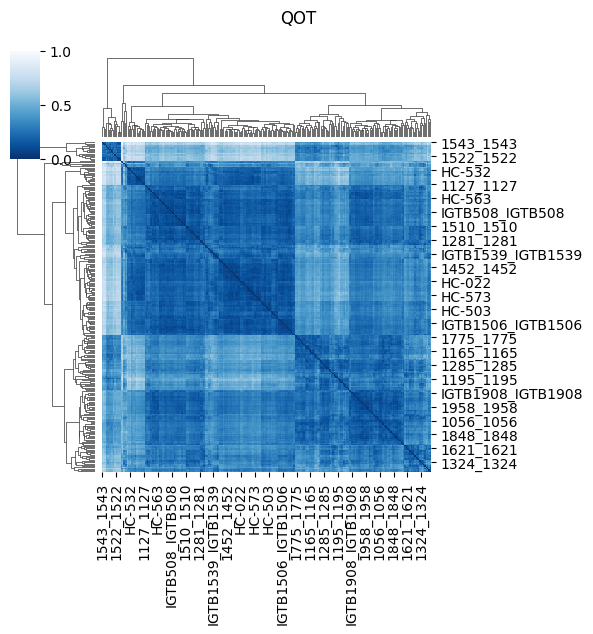

Silhouette Score: 0.16161329865918614
Silhouette Score (PILOT Version): 0.3477850612702997
Results for each num_components:
num_components = 1: GMM time = 372.85769486427307 seconds, WD time = 845.4842345714569 seconds, Total time = 1219.8143978118896 seconds, Silhouette Score = 0.16161329865918614, Silhouette Score (PILOT Version) = 0.3477850612702997


In [ ]:
import time
file_path = '/content/datasets/Datasets/Lupus_PBMC.h5ad'
adata=sc.read_h5ad(file_path)

Extract_Info(adata,  gene_matrix= 'X_pca', type_cell = 'cell_types',id= 'sampleID', progession='Status',dataset_type='rna')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 1
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2,min_samples_for_gmm=1)
    # Calculate QOT


gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="cosine")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 261 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 0.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.10 seconds.
Calculated PHATE in 0.21 seconds.


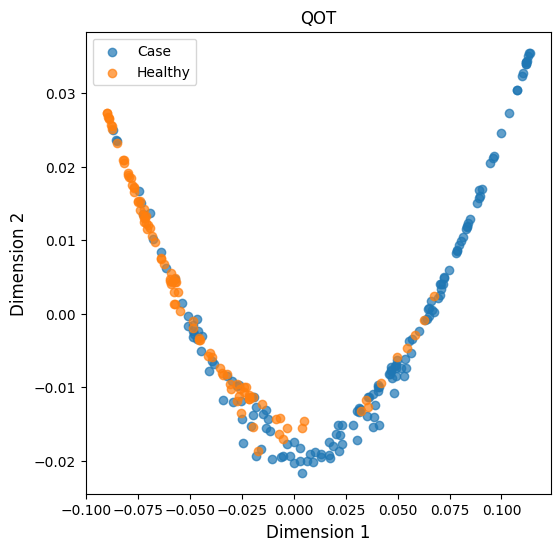

AUCPR: 0.8680289484887187
Spearman's correlation coefficient: 0.5862740354563204
P-value: 1.72556924919992e-25


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=20,dataset_name = 'Lupus')

# Myocardial Infarction

QOT Complete for num_components = 1


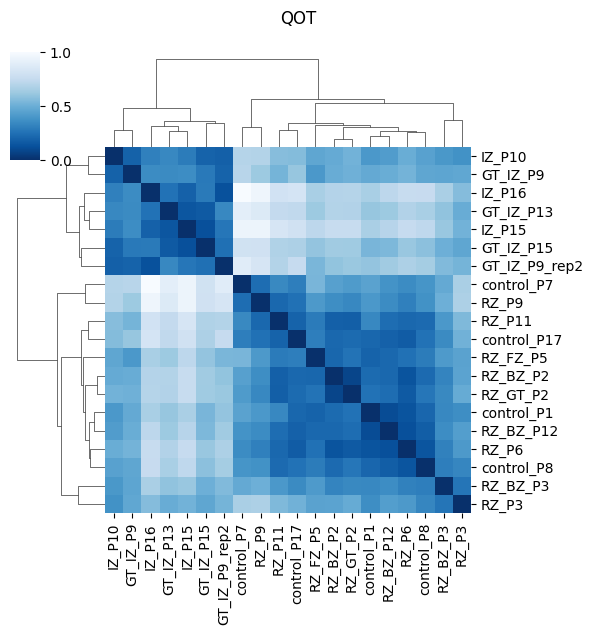

Silhouette Score: 0.5384780221123827
Silhouette Score (PILOT Version): 0.8301295365490262
Results for each num_components:
num_components = 1: GMM time = 49.52083992958069 seconds, WD time = 1.6530396938323975 seconds, Total time = 51.655747175216675 seconds, Silhouette Score = 0.5384780221123827, Silhouette Score (PILOT Version) = 0.8301295365490262


In [ ]:
import time
file_path = '/content/datasets/Datasets/Myocardial Infarction.h5ad'
adata=sc.read_h5ad(file_path)

Extract_Info(adata,  gene_matrix= 'PCA', type_cell = 'cell_subtype',id= 'sampleID', progession='Status',dataset_type='rna')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 1
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2,min_samples_for_gmm=1)    # Calculate QOT


gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="cosine")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 20 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 6
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.05 seconds.


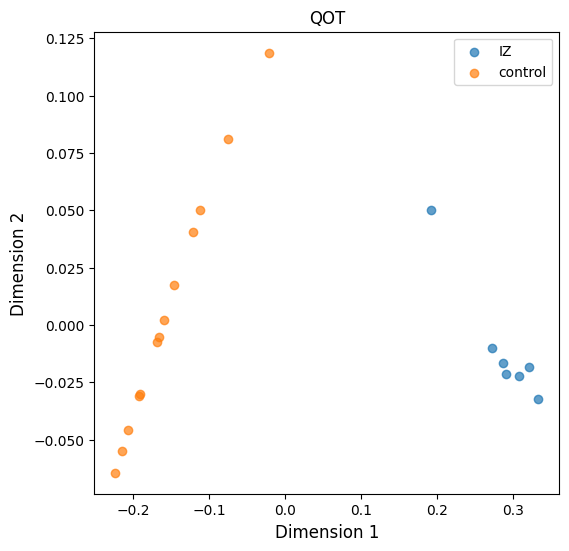

AUCPR: 1.0
Spearman's correlation coefficient: 0.8271701918685112
P-value: 6.8502951899325e-06


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=5,dataset_name = 'MYIO')

# Covid_19_PBMC

QOT Complete for num_components = 3


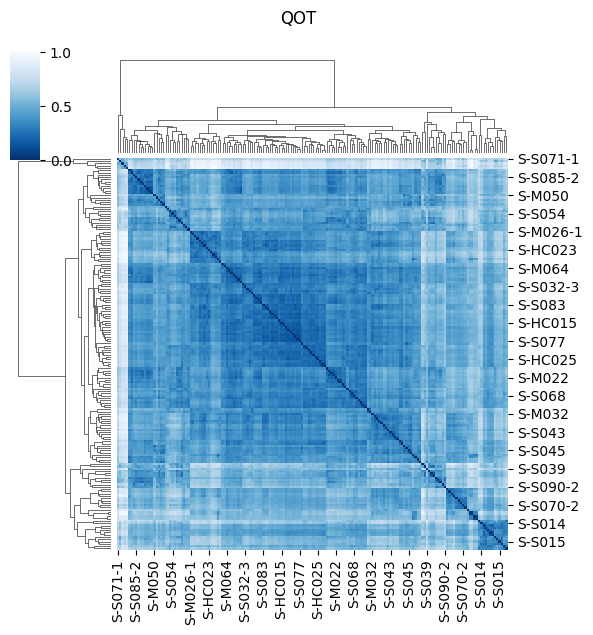

Silhouette Score: -0.08438921491767983
Silhouette Score (PILOT Version): -0.07202812934327367
Results for each num_components:
num_components = 3: GMM time = 1862.73650431633 seconds, WD time = 991.3636322021484 seconds, Total time = 2854.838826417923 seconds, Silhouette Score = -0.08438921491767983, Silhouette Score (PILOT Version) = -0.07202812934327367


In [ ]:
file_path = '/content/datasets/Datasets/Covid_19_PBMC.h5ad'
adata=sc.read_h5ad(file_path)
Extract_Info(adata,  gene_matrix= 'X_pca', type_cell = 'celltype',id= 'sampleID', progession='CoVID-19 severity',dataset_type='rna')
import time

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 3
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2)
    # Calculate QOT


gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="euclidean")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 172 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 30
  Calculated optimal t in 0.14 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.11 seconds.
Calculated PHATE in 0.27 seconds.


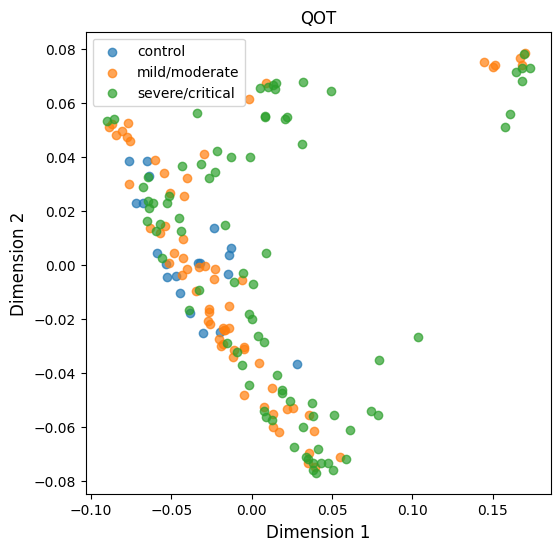

AUCPR: 0.9664988521257243
Spearman's correlation coefficient: 0.3503851134465235
P-value: 2.4530345436982725e-06


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=9,dataset_name = 'Covid')

# follicular lymphoma

QOT Complete for num_components = 1


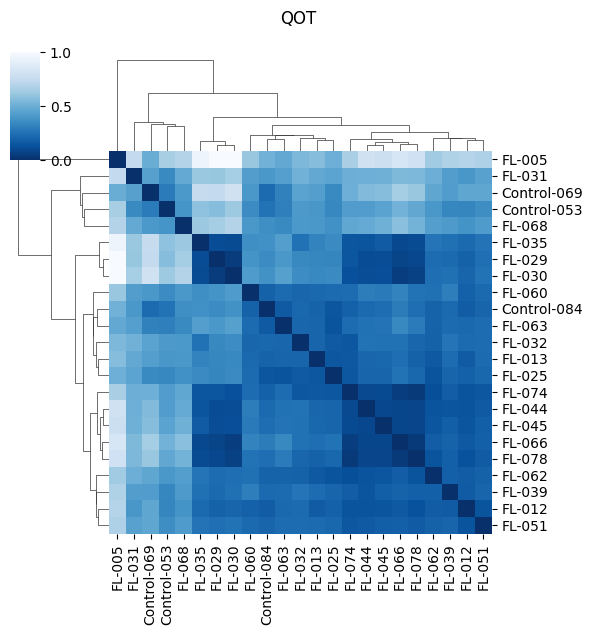

Silhouette Score: 0.24291851088139577
Silhouette Score (PILOT Version): 0.2879268843352571
Results for each num_components:
num_components = 1: GMM time = 46.126620054244995 seconds, WD time = 320.3663854598999 seconds, Total time = 367.41315245628357 seconds, Silhouette Score = 0.24291851088139577, Silhouette Score (PILOT Version) = 0.2879268843352571


In [ ]:

file_path = '/content/drive/My Drive/follicular_lymphoma.h5ad'
adata=sc.read_h5ad(file_path)

Extract_Info(adata,  gene_matrix= 'X_pca', type_cell = 'cell_type',id= 'sample_id', progession='disease',dataset_type='rna')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 1
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2,min_samples_for_gmm=1)    # Calculate QOT


gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="exact")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 23 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 16
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


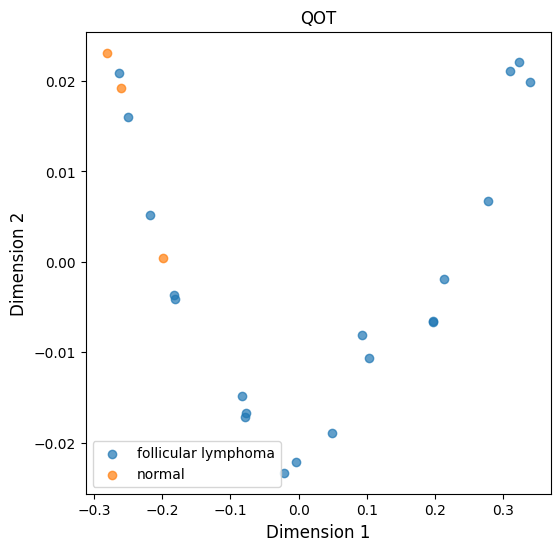

AUCPR: 0.9717391304347825
Spearman's correlation coefficient: 0.50602431370499
P-value: 0.013755540399973152


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=5,dataset_name = 'FOLL')

# Kidney RNA

QOT Complete for num_components = 1


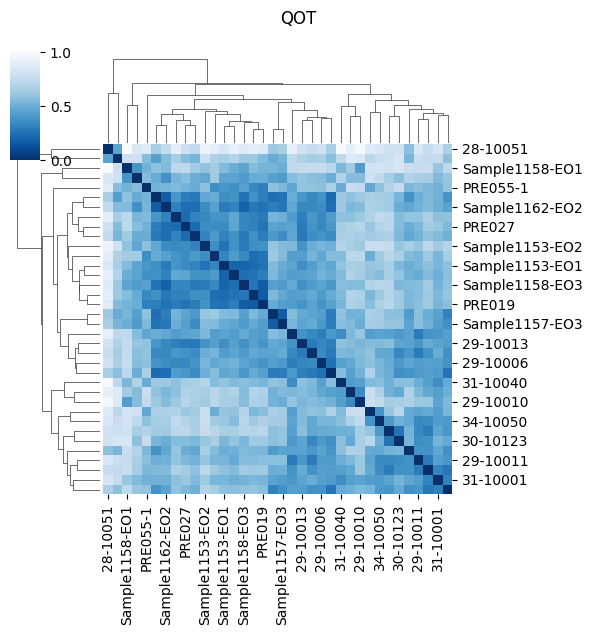

In [ ]:

file_path = '/content/drive/My Drive/Kidney_rna.h5ad'
adata=sc.read_h5ad(file_path)

Extract_Info(adata,  gene_matrix= 'X_pca', type_cell = 'celltype',id= 'donor_id', progession='disease',dataset_type='rna')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 1
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2,min_samples_for_gmm=1)    # Calculate QOT


gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="cosine")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Silhouette Score: 0.1341903337812482
Silhouette Score (PILOT Version): 0.21178904432674214
Results for each num_components:
num_components = 1: GMM time = 84.84553384780884 seconds, WD time = 8.671037912368774 seconds, Total time = 93.9583330154419 seconds, Silhouette Score = 0.1341903337812482, Silhouette Score (PILOT Version) = 0.21178904432674214
Calculating PHATE...
  Running PHATE on precomputed distance matrix with 36 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 20
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


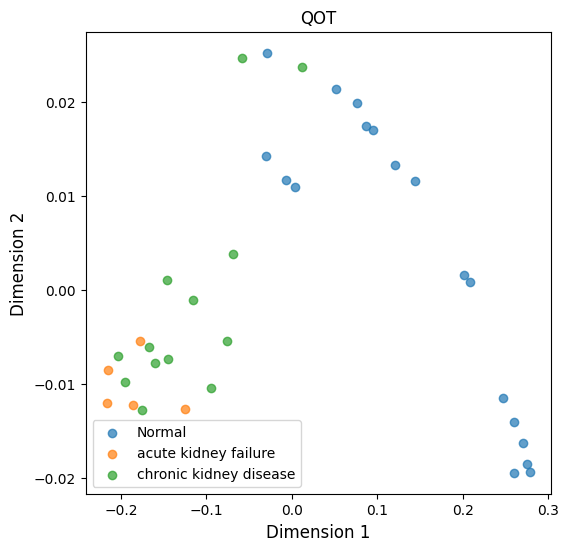

AUCPR: 0.2638888888888889
Spearman's correlation coefficient: -0.8631716757630173
P-value: 1.265208228050112e-11


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=5,dataset_name = 'Kidney_RNA')

# Kidney_IgAN_G

QOT Complete for num_components = 3


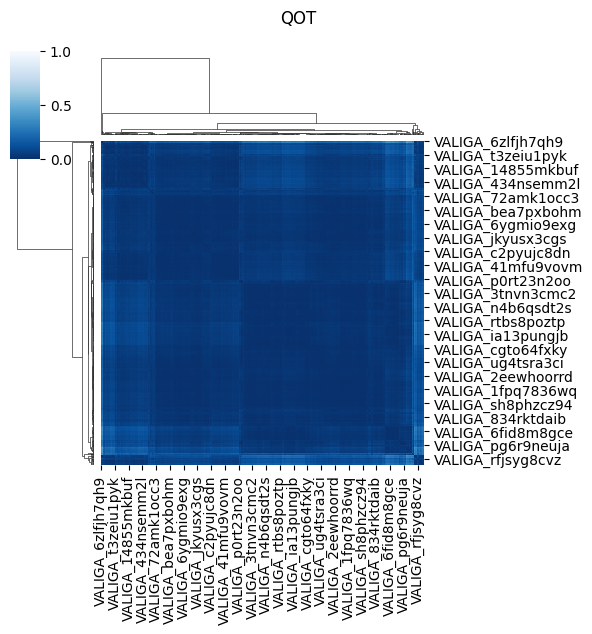

Silhouette Score: 0.14406643793340124
Silhouette Score (PILOT Version): 0.10071840314508952
Results for each num_components:
num_components = 3: GMM time = 118.65202236175537 seconds, WD time = 622.0028471946716 seconds, Total time = 741.7513716220856 seconds, Silhouette Score = 0.14406643793340124, Silhouette Score (PILOT Version) = 0.10071840314508952


In [ ]:
adata=sc.read_h5ad("/content/Kidney_IgAN_G.h5ad")

Extract_Info(adata,  gene_matrix= adata.X, type_cell = 'Cell_type',id= 'sampleID', progession='status')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 3
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2)


gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="cosine")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 634 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculated optimal t in 0.12 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.26 seconds.
Calculated PHATE in 0.54 seconds.


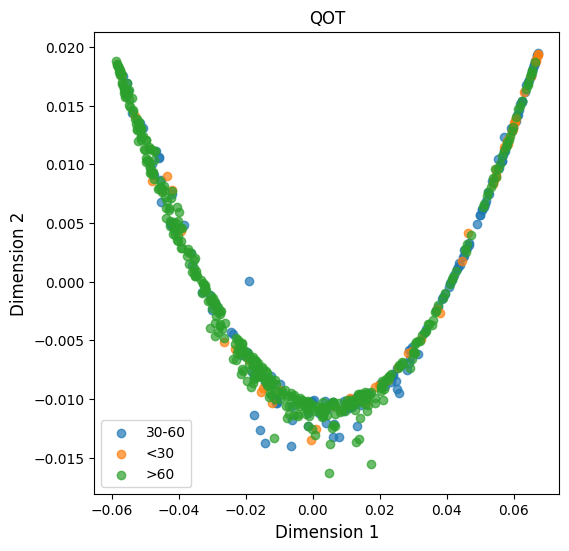

AUCPR: 0.606070193134417
Spearman's correlation coefficient: 0.3633023676804597
P-value: 3.2417640684535424e-21


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=90,dataset_name = 'KID_G')

# Kidney_IgAN_T

QOT Complete for num_components = 3


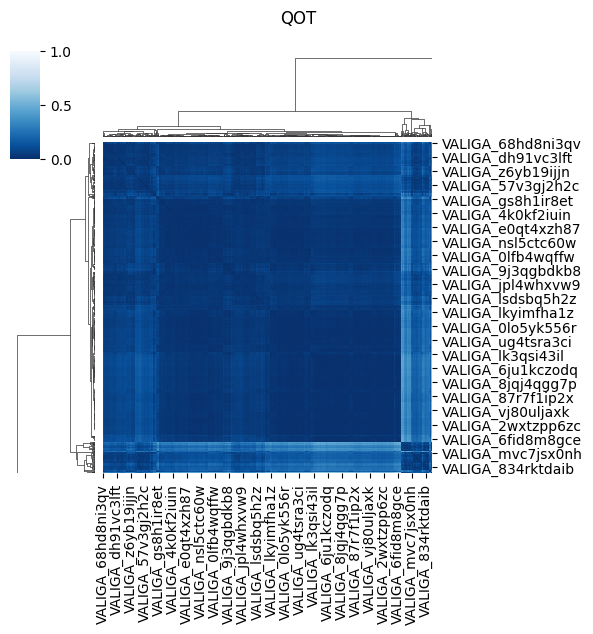

Silhouette Score: 0.15609187394529406
Silhouette Score (PILOT Version): 0.1382034022454494
Results for each num_components:
num_components = 3: GMM time = 35.0226149559021 seconds, WD time = 2129.038067340851 seconds, Total time = 2165.1939573287964 seconds, Silhouette Score = 0.15609187394529406, Silhouette Score (PILOT Version) = 0.1382034022454494


In [ ]:
file_path = '/content/Kidney_IgAN_T.h5ad'

adata=sc.read_h5ad(file_path)



Extract_Info(adata,  gene_matrix= adata.X, type_cell = 'Cell_type',id= 'sampleID', progession='status')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 3
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2)

gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="cosine")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 634 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculated optimal t in 0.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.27 seconds.
Calculated PHATE in 0.54 seconds.


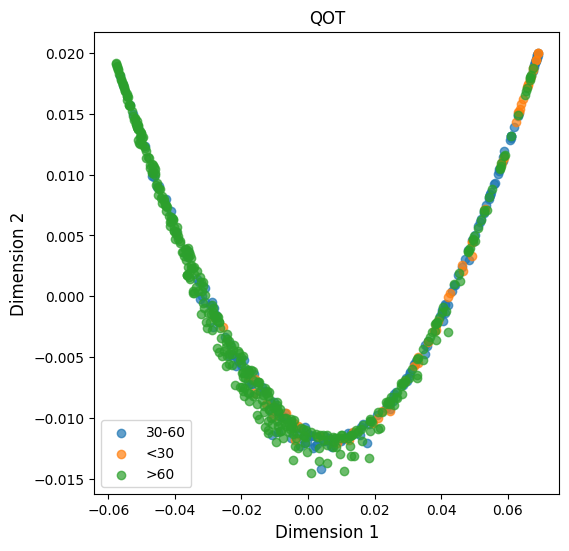

AUCPR: 0.6428228280742362
Spearman's correlation coefficient: 0.429870436549909
P-value: 6.706552751170385e-30


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=90,dataset_name = 'KID_T')

# Kidney_AC_G

QOT Complete for num_components = 2


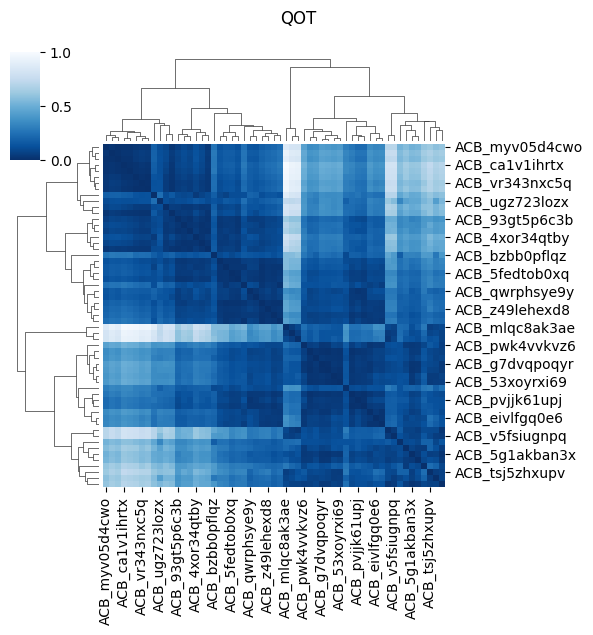

Silhouette Score: 0.33490782078287856
Silhouette Score (PILOT Version): 0.39369980924739284
Results for each num_components:
num_components = 2: GMM time = 35.419782400131226 seconds, WD time = 12.598304510116577 seconds, Total time = 48.486082553863525 seconds, Silhouette Score = 0.33490782078287856, Silhouette Score (PILOT Version) = 0.39369980924739284


In [ ]:
file_path = '/content/Kidney_AC_G.h5ad'

adata=sc.read_h5ad(file_path)

adata.X = adata.X.toarray()


Extract_Info(adata,  gene_matrix= adata.X, type_cell = 'cell_type',id= 'Patient_ID', progession='status')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 2
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2)
gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="cosine")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 57 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.05 seconds.


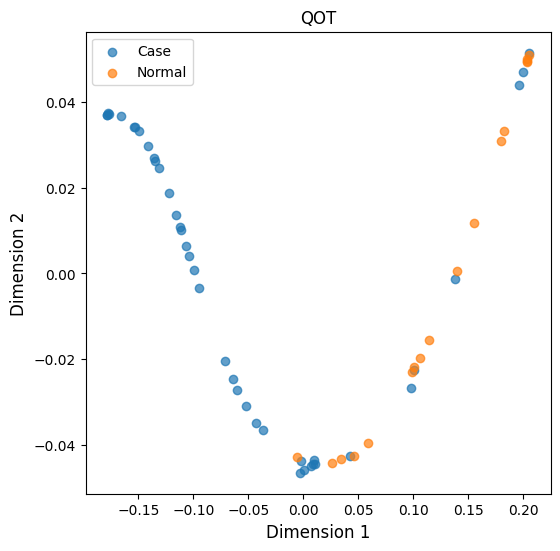

AUCPR: 0.918859649122807
Spearman's correlation coefficient: 0.6223567694022035
P-value: 2.361459290048427e-07


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=10,dataset_name = 'Kidney_AC_G',flip_condition=True)

# Kidney_AC_T

QOT Complete for num_components = 6


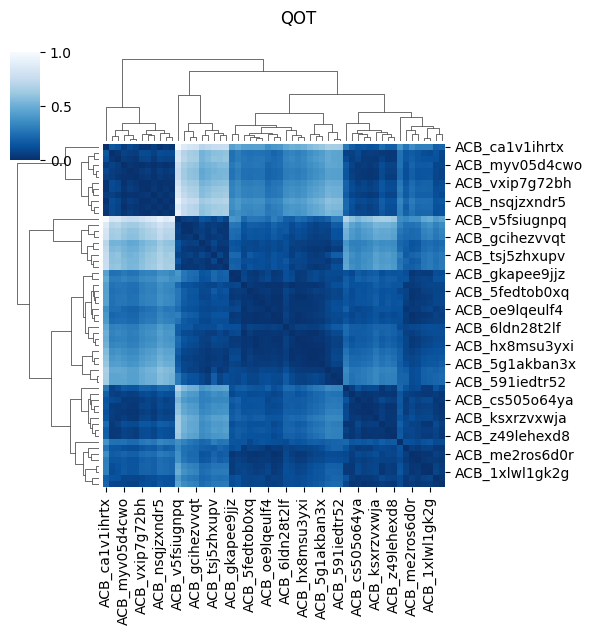

Silhouette Score: 0.1764871641939175
Silhouette Score (PILOT Version): 0.16830577543165529
Results for each num_components:
num_components = 6: GMM time = 15.416733980178833 seconds, WD time = 18.110242128372192 seconds, Total time = 34.13612341880798 seconds, Silhouette Score = 0.1764871641939175, Silhouette Score (PILOT Version) = 0.16830577543165529


In [ ]:
file_path = '/content/Kidney_AC_G.h5ad'

adata=sc.read_h5ad(file_path)

adata.X = adata.X.toarray()


Extract_Info(adata,  gene_matrix= adata.X, type_cell = 'cell_type',id= 'Patient_ID', progession='status')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 6
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2)
gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="cosine")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 57 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.05 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.02 seconds.
Calculated PHATE in 0.09 seconds.


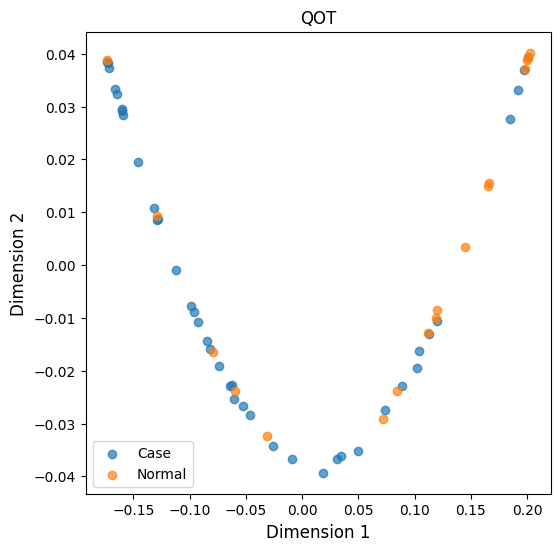

AUCPR: 0.8864035087719299
Spearman's correlation coefficient: 0.384602497945182
P-value: 0.0031379770436935944


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=10,dataset_name = 'Kidney_AC_T',flip_condition=True)

# Diabete

QOT Complete for num_components = 1


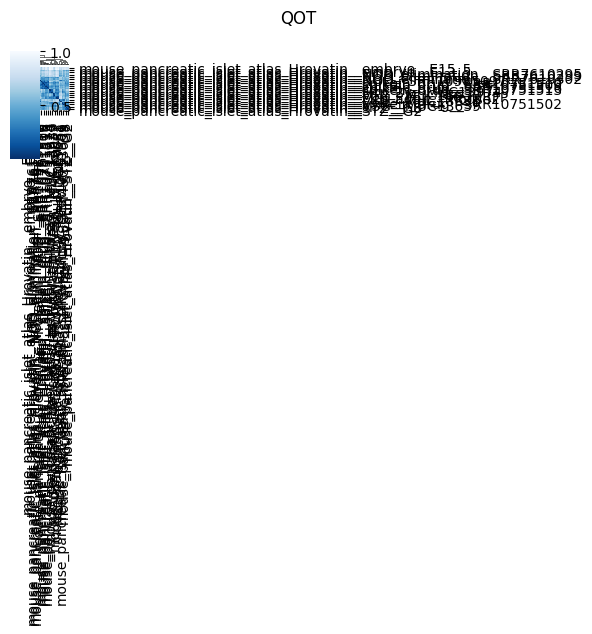

Silhouette Score: 0.1628476548178555
Silhouette Score (PILOT Version): 0.15567060504216818
Results for each num_components:
num_components = 1: GMM time = 72.96700119972229 seconds, WD time = 11.16170334815979 seconds, Total time = 84.81565260887146 seconds, Silhouette Score = 0.1628476548178555, Silhouette Score (PILOT Version) = 0.15567060504216818


In [ ]:
adata=sc.read_h5ad("/content/drive/MyDrive/diabetes_pca.h5ad")

Extract_Info(adata,  gene_matrix= 'X_pca', type_cell = 'cell_type',id= 'donor_id', progession='disease',dataset_type='rna')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 1
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2,min_samples_for_gmm=1)    # Calculate QOT


gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="cosine")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 56 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 27
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


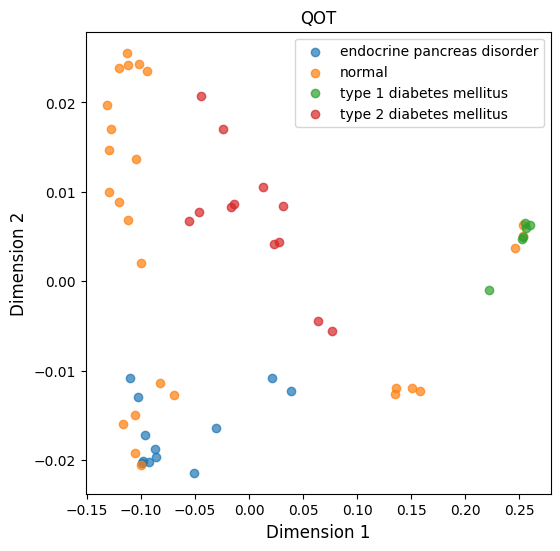

AUCPR: 0.7733730158730159
Spearman's correlation coefficient: 0.5192418470255467
P-value: 4.1240076862192736e-05


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=10,dataset_name = 'diabete')

# PDAC

QOT Complete for num_components = 1


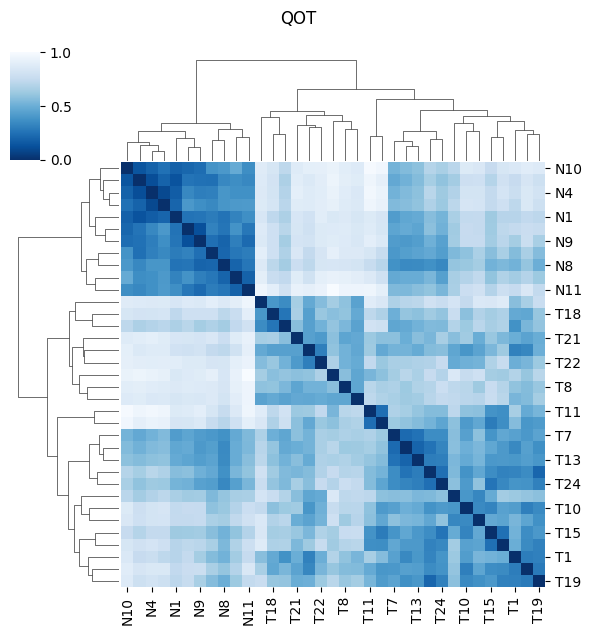

Silhouette Score: 0.35938744926208477
Silhouette Score (PILOT Version): 0.7146459970273847
Results for each num_components:
num_components = 1: GMM time = 29.086947679519653 seconds, WD time = 1.3371145725250244 seconds, Total time = 30.824188470840454 seconds, Silhouette Score = 0.35938744926208477, Silhouette Score (PILOT Version) = 0.7146459970273847


In [ ]:
file_path = '/content/drive/My Drive/PDAC.h5ad'
adata=sc.read_h5ad(file_path)

Extract_Info(adata,  gene_matrix= 'X_pca', type_cell = 'cell_types',id= 'sampleID', progession='status',dataset_type='rna')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 1
Gaussian_Mixture_Representation(adata, num_components=num_components, random_state=2, min_samples_for_gmm=16)

gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata, method="cosine")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


Calculating PHATE...
  Running PHATE on precomputed distance matrix with 35 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 12
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


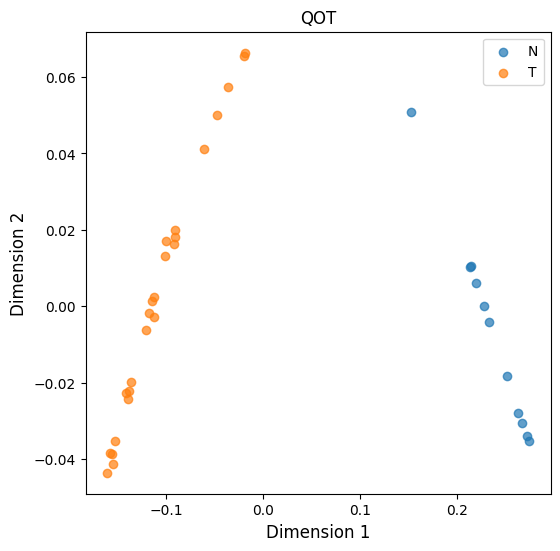

AUCPR: 0.6988095238095238
Spearman's correlation coefficient: -0.8043996665398438
P-value: 5.813972939783747e-09


In [ ]:
perform_analysis_phate_and_calculate_aucpr(adata,knn_number=6,dataset_name = 'PDAC')

# Simulation Missing Celltype

QOT Complete for num_components = 1


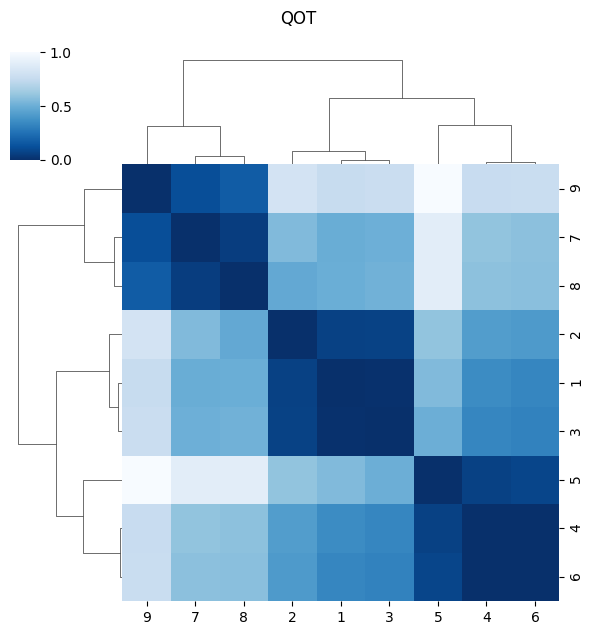

Silhouette Score: 0.8622088070845381
Silhouette Score (PILOT Version): 0.9790920034140809
Results for each num_components:
num_components = 1: GMM time = 0.35781073570251465 seconds, WD time = 0.46213603019714355 seconds, Total time = 1.2278897762298584 seconds, Silhouette Score = 0.8622088070845381, Silhouette Score (PILOT Version) = 0.9790920034140809


In [ ]:
# Specify the path in your Google Drive where you want to save the file
drive_path = '/content/drive/My Drive/simulate_miss_new_1.h5ad'

# Save the AnnData object to the specified path
adata=sc.read_h5ad(drive_path )
Extract_Info(adata,  gene_matrix= adata.X, type_cell = 'Cell_type',id= 'sampleID', progession='status')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 1
Gaussian_Mixture_Representation(adata, num_components=num_components)

gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata,method = "exact")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


# Simulation Uniform

QOT Complete for num_components = 1


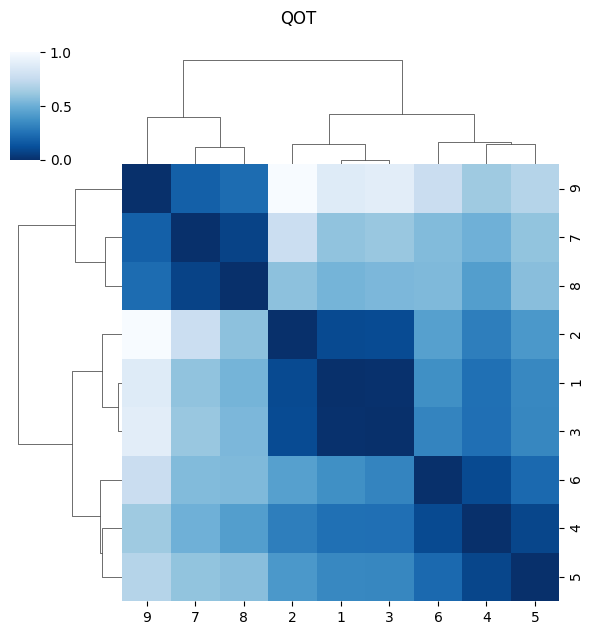

Silhouette Score: 0.7060006004941211
Silhouette Score (PILOT Version): 0.925207152933852
Results for each num_components:
num_components = 1: GMM time = 0.46410679817199707 seconds, WD time = 0.5544462203979492 seconds, Total time = 1.4210495948791504 seconds, Silhouette Score = 0.7060006004941211, Silhouette Score (PILOT Version) = 0.925207152933852


In [ ]:
drive_path = '/content/simulate_balance_new_1 (1).h5ad'

# Save the AnnData object to the specified path
adata=sc.read_h5ad(drive_path)
# Specify the path in your Google Drive where you want to save the file

Extract_Info(adata,  gene_matrix= adata.X, type_cell = 'Cell_type',id= 'sampleID', progession='status')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 1
Gaussian_Mixture_Representation(adata, num_components=num_components)

gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata,method = "exact")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")


# Simulation Unbalance

QOT Complete for num_components = 9


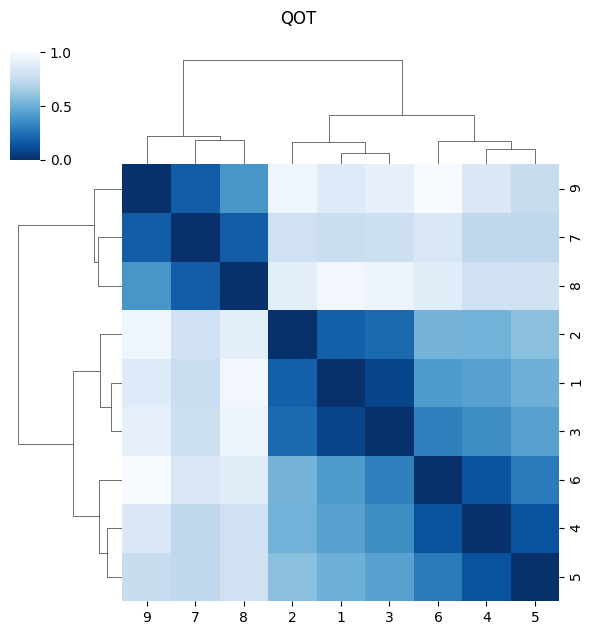

Silhouette Score: 0.645165083840601
Silhouette Score (PILOT Version): 0.8801350261017357
Results for each num_components:
num_components = 9: GMM time = 1.2430119514465332 seconds, WD time = 23.780245304107666 seconds, Total time = 25.415077447891235 seconds, Silhouette Score = 0.645165083840601, Silhouette Score (PILOT Version) = 0.8801350261017357


In [ ]:
drive_path = '/content/drive/My Drive/simulate_unbalance_new_1.h5ad'

adata=sc.read_h5ad(drive_path)
# Specify the path in your Google Drive where you want to save the file

Extract_Info(adata,  gene_matrix= adata.X, type_cell = 'Cell_type',id= 'sampleID', progession='status')

# Store the time taken for GMM, WD, and total for each num_components
results = {}


total_start_time = time.time()  # Start time for the total process

    # Apply Gaussian Mixture Representation
gmm_start_time = time.time()  # Start time for GMM
num_components = 9
Gaussian_Mixture_Representation(adata, num_components=num_components)

gmm_end_time = time.time()  # End time for GMM
gmm_time = gmm_end_time - gmm_start_time  # Calculate GMM time

    # Calculate QOT (including WD)
wd_start_time = time.time()  # Start time for WD
calculate_qot(adata,method = "exact")


wd_end_time = time.time()  # End time for WD
wd_time = wd_end_time - wd_start_time  # Calculate WD time
print(f"QOT Complete for num_components = {num_components}")

    # Visualize and evaluate
score_1, score_2 = visualize_and_evaluate(adata)

total_end_time = time.time()  # End time for the total process
total_time = total_end_time - total_start_time  # Calculate total time

    # Store the times and scores for the current num_components
results[num_components] = {
        'gmm_time': gmm_time,
        'wd_time': wd_time,
        'total_time': total_time,
        'score_1': score_1,
        'score_2': score_2
    }

# Print the results for each num_components
print("Results for each num_components:")
for num_components, data in results.items():
    print(f"num_components = {num_components}: GMM time = {data['gmm_time']} seconds, WD time = {data['wd_time']} seconds, Total time = {data['total_time']} seconds, Silhouette Score = {data['score_1']}, Silhouette Score (PILOT Version) = {data['score_2']}")
